In [111]:
# Group 16
# Sjoerd Bootsma: 5242053
# Gijs van der Klink: 5389283
# Jelle Weijland: 5093457

#------------------------------------------------------------------------------------------------

import math
import pandas as pd
import os
import numpy as np
from datetime import datetime, time, timedelta
import matplotlib as plt
import matplotlib.dates as mdates

#------------------------------------------------------------------------------------------------

data_file_path = 'data/AirportData.xlsx'
data_file_path2 = 'data/Group16.xlsx'

#------------------------------------------------------------------------------------------------
# Fleet data
fleet_data = pd.DataFrame({
    'Type': [1, 2, 3],
    'Speed': [800, 850, 920],  # Speed in km/h
    'Cargo_Capacity': [23000, 35000, 120000],  # Cargo capacity in kg
    'TAT': [90, 120, 150],  # Average Turn-Around Time in minutes
    'Max_Range': [1500, 3300, 6300],  # Maximum range in km
    'RQ': [1400, 1600, 1800],  # Runway required in meters
    'Lease_Cost': [2143, 4857, 11429],  # Lease cost in EUR/day
    'Fixed_Cost': [750, 1500, 3125],  # Fixed operating cost per flight leg in EUR
    'Time_Cost': [1875, 1938, 3500],  # Cost per hour in EUR
    'Fuel_Cost': [2.5, 5, 9.5],  # Fuel cost parameter
    'Fleet': [2, 2, 1]  # Fleet count
    })

#------------------------------------------------------------------------------------------------
#load and process data 

def load_airport_data(file_path, sheet_name='Airport', output_csv_path='AirportData.csv'):
    airport_data = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
    airport_data_transposed = airport_data.transpose()
    airport_data_transposed.columns = airport_data_transposed.iloc[0]
    airport_data_transposed = airport_data_transposed[1:]
    airport_data_transposed.to_csv(output_csv_path, index=False)    
    return airport_data_transposed

def calculate_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Aarde straal in kilometers
    lat1, lon1 = math.radians(lat1), math.radians(lon1)
    lat2, lon2 = math.radians(lat2), math.radians(lon2)
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    a = math.sin(delta_lat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(delta_lon / 2)**2
    delta_sigma = 2 * math.asin(math.sqrt(a))
    return R * delta_sigma

def calculate_distance_matrix(latitudes, longitudes):
    num_airports = len(latitudes)
    distance_matrix = [[0 for _ in range(num_airports)] for _ in range(num_airports)]
    for i in range(num_airports):
        for j in range(num_airports):
            if i != j:
                distance_matrix[i][j] = calculate_distance(latitudes[i], longitudes[i], latitudes[j], longitudes[j])
    return distance_matrix

def calculate_distance_dataframe(airport_data):
    latitudes = airport_data['Latitude (deg)'].astype(float).values
    longitudes = airport_data['Longitude (deg)'].astype(float).values
    city_names = airport_data['IATA code'].tolist()
    distance_matrix = calculate_distance_matrix(latitudes, longitudes)
    distance_df = pd.DataFrame(distance_matrix, index=city_names, columns=city_names)
    return distance_df.round(1)

def save_and_print_fra_distances(distance_df, output_csv_path='DistanceMatrix_FRA.csv'):
    if 'FRA' in distance_df.index and 'FRA' in distance_df.columns:
        fra_distances = distance_df.loc['FRA']
        filtered_distance_df = pd.DataFrame({"Distance to/from FRA": fra_distances})
        filtered_distance_df.to_csv(output_csv_path, index=True)


def process_demand_data(file_path2, sheet_name):
    data = pd.read_excel(
        file_path2, 
        sheet_name=sheet_name, 
        header=None, 
        usecols=lambda x: x != 0  
    )
    data.columns = [f"Column_{i}" for i in range(1, data.shape[1] + 1)]
    data = data.rename(columns={"Column_1": "Departure", "Column_2": "Arrival"})
    num_time_columns = 30 
    time_columns = {f"Column_{i + 3}": i for i in range(num_time_columns)}  
    data = data.rename(columns=time_columns)
    fra_related_rows = data[
        (data["Departure"] == "FRA") | (data["Arrival"] == "FRA")
    ].reset_index(drop=True)


    fra_related_rows.to_csv("DemandData.csv", index=False)

    return fra_related_rows

distance_matrix_path = 'DistanceMatrix_FRA.csv'

def calculate_operating_costs(distances, fleet_data):
    total_costs_df = pd.DataFrame(index=distances.index)

    for _, row in fleet_data.iterrows():
        type_name = row['Type']
        fixed_cost = row['Fixed_Cost']
        time_cost_param = row['Time_Cost']
        fuel_cost_param = row['Fuel_Cost']
        airspeed = row['Speed']

        # Fixed operating cost 
        fixed_operating_cost = fixed_cost

        # Time-based costs 
        time_based_costs = (time_cost_param * distances / airspeed).round(2)

        # Fuel costs (in euros)
        fuel_costs = (fuel_cost_param * 1.42 *0.97*  distances / 1.5).round(2)

        # Total operating cost 
        total_costs = fixed_operating_cost + time_based_costs + fuel_costs
        total_costs_df[type_name] = total_costs.round(2)

    return total_costs_df

def calculate_and_save_flight_times(fra_distances, fleet_data, output_csv_path):
    flight_times_df = pd.DataFrame(index=fra_distances.index)

    for _, row in fleet_data.iterrows():
        type_name = row['Type']
        speed = row['Speed']
        tat = row['TAT']
        
        flight_times_df[type_name] = (
            ((((fra_distances / speed) + 0.5) * 60) + tat)
            .apply(lambda x: int(np.ceil(x / 6.0) * 6))  # averaged on multiple of 6
        )

    flight_times_df.to_csv(output_csv_path, index=True)
    
process_demand_data(data_file_path2, 'Group 16')
airport_data = load_airport_data(data_file_path)
distance_df = calculate_distance_dataframe(airport_data)
save_and_print_fra_distances(distance_df)
distances = pd.read_csv(distance_matrix_path, index_col=0)["Distance to/from FRA"]
operating_costs = calculate_operating_costs(distances, fleet_data)
output_csv_path = 'OperatingCosts_FRA.csv'
operating_costs.to_csv(output_csv_path, index=True)
calculate_and_save_flight_times(distances, fleet_data, 'FlightTimes_FRA.csv')


In [112]:
# Process csv files 

df_operatingcost = pd.read_csv("OperatingCosts_FRA.csv", index_col=0)
df_operatingcost.columns = [1,2,3]
df_flight_times = pd.read_csv("FlightTimes_FRA.csv", index_col=0)
df_flight_times.columns = [1,2,3]
df_distance = pd.read_csv("DistanceMatrix_FRA.csv", index_col=0)
df_airportdata = pd.read_csv("AirportData.csv", index_col=0)
df_demandata = pd.read_csv("DemandData.csv", index_col=0)

# Reset index for demanddata file
df_demandata.reset_index(inplace=True)


#------------------------------------------------------------------------------------------------
#Define functions to calculate flight parameters 

def calc_cost(k, i, j):
    # Controleer of één van de luchthavens Frankfurt is
    if i == 'FRA':
        # Kosten voor vertrek vanuit Frankfurt naar luchthaven j
        cost = df_operatingcost.loc[j, k]
    elif j == 'FRA':
        # Kosten voor aankomst in Frankfurt vanuit luchthaven i
        cost = df_operatingcost.loc[i, k]   
    else:
        raise ValueError("Eén van de luchthavens moet Frankfurt zijn")

    return cost

def calc_flight_time(k, i, j):
    # Controleer of één van de luchthavens Frankfurt is
    if i == 'FRA':
        # Vluchttijd voor vertrek vanuit Frankfurt naar luchthaven j
        flight_time = df_flight_times.loc[j, k]
    elif j == 'FRA':
        # Vluchttijd voor aankomst in Frankfurt vanuit luchthaven 
        flight_time = df_flight_times.loc[i, k]
    else:
        raise ValueError("Eén van de luchthavens moet Frankfurt zijn")

    return flight_time


def calc_distance(i, j):
    # Controleer of één van de luchthavens Frankfurt is
    if i == 'FRA':
        # Afstand vanuit Frankfurt naar luchthaven j
        distance = df_distance.loc[j, 'Distance to/from FRA']
    elif j == 'FRA':
        # Afstand naar Frankfurt vanuit luchthaven i
        distance = df_distance.loc[i, 'Distance to/from FRA']
    else:
        raise ValueError("Eén van de luchthavens moet Frankfurt zijn")
    
    return distance


def calc_revenue(distance, cargoload):
    revenue = 0.26 / 1000 * distance * cargoload
    return revenue


def calc_demand(timestamp, i, j, reference_time):

    # Calculate the number of 4-hour intervals from the reference_time
    time_diff = timestamp - reference_time


    # Calculate the interval index: divide by 4 hours (14400 seconds)
    interval_index = time_diff.total_seconds() // 14400  # 14400 seconds = 4 hours

    # Filter the correct row based on origin and destination
    demand_row = df_demandata[(df_demandata['Departure'] == i) & (df_demandata['Arrival'] == j)]

    # Check if the row is empty
    if demand_row.empty:
        raise ValueError(f"Geen gegevens gevonden voor origin {i} en destination {j}.")

    # Get the base demand value for the current interval
    demand_value = demand_row.iloc[0, int(interval_index) + 2]  # +2 to account for 'Departure' and 'Arrival' columns

    # Calculate demand from previous intervals (if possible)
    demand_previous_1 = demand_row.iloc[0, int(interval_index) + 1] if interval_index > 0 else 0  # 1 column before
    demand_previous_2 = demand_row.iloc[0, int(interval_index)] if interval_index > 1 else 0  # 2 columns before

    # Calculate total demand with 20% correction from earlier columns
    total_demand = demand_value + 0.2 * demand_previous_1 + 0.2 * demand_previous_2

    return total_demand
#------------------------------------------------------------------------------------------------
# functions to ensure constraints 

def check_flightfeasability(aircraft_type, origin, destination, distance, fleet_data):
    check = True
    # print(aircraft_type, origin, destination, distance, fleet_data)

    # Haal maximale vliegbereik en benodigde baanlengte op voor het vliegtuigtype
    max_range = fleet_data.loc[fleet_data['Type'] == aircraft_type, 'Max_Range'].values[0]
    min_runway_required = fleet_data.loc[fleet_data['Type'] == aircraft_type, 'RQ'].values[0]

    # Controleer of de afstand binnen het bereik van het vliegtuig ligt
    if max_range < distance:
        check = False

    # Haal de lengte van de startbaan op voor vertrek- en aankomstluchthaven uit de CSV
    runway_origin = df_airportdata.loc[df_airportdata['IATA code'] == origin, 'Runway (m)'].values[0]
    runway_destination = df_airportdata.loc[df_airportdata['IATA code'] == destination, 'Runway (m)'].values[0]

    # Controleer of de startbanen lang genoeg zijn
    if min_runway_required > runway_origin or min_runway_required > runway_destination:
        check = False

    return check

def check_minimum_daily_flight_time(route, min_hours_per_day=6):
    total_flight_time = 0  # Total flight time in minutes
    start_date = route['Departure Time'].min().date()
    end_date = route['Arrival Time'].max().date()

    # Calculate the total flight time for the entire route
    for index, row in route.iterrows():
        flight_duration = (row['Arrival Time'] - row['Departure Time']).total_seconds() / 60  # Convert to minutes
        total_flight_time += flight_duration

    num_days = (end_date - start_date).days + 1  # Total number of days in the route
    average_flight_time_per_day = (total_flight_time / 60) / num_days  # Convert to hours per day

    return average_flight_time_per_day >= min_hours_per_day


#------------------------------------------------------------------------------------------------
#calculate flight parameters 

def calc_flight_parameters(timestamp, origin, destination, aircraft_type):
    # Calculate distance between origin and destination
    distance = calc_distance(origin, destination)
    
    # Calculate flight time for the given aircraft type
    flight_time = calc_flight_time(aircraft_type, origin, destination)  # Assume this returns a `datetime.timedelta`
    
    # Get capacity for the given aircraft type from fleet data
    capacity = fleet_data.loc[fleet_data['Type'] == aircraft_type, 'Cargo_Capacity'].values[0]
    
    # Calculate flow between origin and destination (assuming demand is already defined elsewhere)
    demand = calc_demand(timestamp, origin, destination, reference_time=datetime(2025,1,1,0,0))  
    cargoload = min(demand, capacity)
    
    # Calculate revenue based on distance and flow
    revenue = calc_revenue(distance, cargoload)
    
    # Calculate cost for the flight
    cost = calc_cost(aircraft_type, origin, destination)
    
    # Calculate profit as revenue minus cost
    profit = revenue - cost
    
    # Calculate the arrival time by adding flight_time (timedelta) to timestamp
    arrival_time = timestamp + timedelta(minutes=int(flight_time))
    
    return cost, revenue, profit, cargoload, distance, arrival_time, flight_time


#------------------------------------------------------------------------------------------------
#Update demand

def update_demand_data(selected_route):
    # Load the updated CSV file each time to ensure the latest version is used
    df_demand = pd.read_csv("DemandData.csv")

    # Update the global df_demandata to use the latest data in `calc_demand`
    global df_demandata
    df_demandata = df_demand

    # Iterate over each leg in the selected route
    for index, row in selected_route.iterrows():
        route = row['Route'].split(' - ')
        origin, destination = route[0], route[1]
        flow = row['Cargoload (kg)']  # Use the cargo load directly from the route

        # Identify the correct time interval in the demand DataFrame based on departure time
        time_interval_index = (row['Departure Time'] - datetime(2025, 1, 1, 0, 0)).total_seconds() // 14400  # 4 hours in seconds
        time_interval_index = int(time_interval_index) + 2  # Offset for 'Departure' and 'Arrival' columns

        demand_row = df_demand[(df_demand['Departure'] == origin) & (df_demand['Arrival'] == destination)]
        if not demand_row.empty:
            demand_index = demand_row.index[0]

            # Subtract flow from the current and previous intervals
            for interval_offset in range(0, -3, -1):  # Current, -1, and -2 intervals
                col_index = time_interval_index + interval_offset
                if col_index >= 2:  # Ensure valid column index
                    current_demand = df_demand.iloc[demand_index, col_index]
                    subtract_flow = min(flow, current_demand)
                    df_demand.iloc[demand_index, col_index] -= subtract_flow
                    flow -= subtract_flow

    # Overwrite the original CSV file and update the global demand DataFrame
    df_demand.to_csv("DemandData.csv", index=False)
    df_demandata = df_demand



In [113]:
# Define Node and Link classes

class Node():
    # Initializes a Node with time, airport, and default values for links, profit, and time elapsed
    def __init__(self, Time, airport):
        self.Time = Time
        self.Airport = airport
        self.inLink = None
        self.outLink = None
        self.Tot_profit = None
        self.Time_elapsed = 0

    # Adds an incoming link to the node
    def add_inLink(self, link):
        self.inLink = link

    # Adds an outgoing link to the node
    def add_outLink(self, link):
        self.outLink = link

    # Calculates total profit at this node
    def add_Profit(self):
        self.Tot_profit = self.outLink.Profit + self.outLink.To.Tot_profit

    # Updates the time elapsed for this node
    def add_Time(self, onground=False):
        if onground is True:
          self.Time_elapsed += 6
        else:
          self.Time_elapsed = self.Time_elapsed + self.outLink.To.Time_elapsed

    # String representation of the node
    def __str__(self):
        return f'Node at time: {self.Time} and airport: {self.Airport}'

    # Representation used for debugging
    def __repr__(self):
        return f'{self.Time}_{self.Airport}_{round(self.Tot_profit)}'

class Link():
    # Initializes a Link with origin, destination, distance, cost, revenue, profit, cargoload , and flighttime
    def __init__(self, origin, destination, distance, cost, revenue, profit, cargoload, flighttime):
        self.From = origin
        self.To = destination
        self.Distance = distance
        self.cost = cost
        self.revenue = revenue
        self.Profit = profit
        self.cargoload = cargoload
        self.Flighttime = flighttime


def add_time(time_current, hours, minutes=0):
    
    # Add the hours and minutes using timedelta
    return time_current + timedelta(hours=hours, minutes=minutes)

In [114]:

#initialize input for dynamic model
lease_costs = {1: 2143, 2: 4857, 3: 11429}
profit_dict = {}
aircraft_usage_dict = {}
df_airports = df_airportdata
df_airports = df_airports.set_index(df_airports.columns[0])

total_aircraft = {1: 2, 2:2, 3:1} 
selected_aircraft_dict = {1: 0, 2: 0, 3:0}
total_profit_aircraft = 0
routes_selected = {}


# Big loop with dynamic programming inner loop
route_index = 1
while sum(total_aircraft.values()) != 0:
  profits = {}
  routes = {}
  for aircraft in [1,2,3]:
    if total_aircraft[aircraft] <= 0:
      profits[aircraft] = 0
      continue
    aircraft_type = aircraft

    # inner loop dynamic program 

    # Define start and end nodes
    start_node = Node(datetime(2025, 1, 1, 0, 0), 'FRA')
    end_node = Node(datetime(2025, 1, 5, 23, 54), 'FRA')  

    # Generate a list of timestamps with 6-minute intervals
    start_time = start_node.Time  # Assuming `time` attribute of the Node is a datetime
    end_time = end_node.Time      # Assuming `time` attribute of the Node is a datetime
    lst_time = []

    current_time = start_time
    while current_time <= end_time:
        lst_time.append(current_time)
        current_time += timedelta(minutes=6)
    lst_time = lst_time[::-1]
    lst_airports = list(df_airports.index) 

    nodes_dict = {}

    #keep track of innerloop progress
    i = 0
    for timestamp in lst_time: #loop through all timestamps starting at the end 
        i += 1
        if i % 100 == 0:
          print(round(i/1200*100, 2), '%')

        if timestamp == end_node.Time:
            end_node.Tot_profit = 0
            end_node.Time_elapsed = 0
            end_node.add_outLink('Dummy')
            nodes_dict[timestamp] = {i: None for i in df_airports.index}
            nodes_dict[timestamp]['FRA'] = end_node
    
        else:
            current_nodes = {i: None for i in df_airports.index}
            prev_nodes = nodes_dict[add_time(timestamp, 0, 6)]

            for airport in lst_airports:
              if airport == 'FRA':
                  best_profit = prev_nodes['FRA'].Tot_profit
                  best_airport = 'FRA'

                  for airport_to in lst_airports:
                    if airport_to != 'FRA':
                        destination = airport_to
                        origin = 'FRA'
                        cost, revenue, profit, cargoload, distance, arrival_time, flight_time = calc_flight_parameters(timestamp, origin, destination, aircraft_type)

                        if arrival_time > timestamp and airportcheck == True:
                          # Check if arrival_time exists in nodes_dict and airport_to exists within that specific timestamp's sub-dictionary
                          if arrival_time in nodes_dict and airport_to in nodes_dict[arrival_time] and nodes_dict[arrival_time][airport_to] is not None:
                              # Proceed with the logic if the node exists
                              # if add_time(flight_time, nodes_dict[arrival_time][airport_to].Time_elapsed.hour, nodes_dict[arrival_time][airport_to].Time_elapsed.minute) <= time(18, 0):
                              total_profit = profit + nodes_dict[arrival_time][airport_to].Tot_profit

                              if total_profit > best_profit:
                                  best_profit = total_profit
                                  best_airport = airport_to
                          else:
                              pass


                  # print(timestamp, best_airport)
                  if best_airport == 'FRA':
                    # print('Stay at hub')
                    destination_node = prev_nodes['FRA']
                    new_node = Node(timestamp, 'FRA')
                    new_link = Link(new_node, destination_node, 0, 0, 0, 0, 0, time(0,0))
                    new_node.add_outLink(new_link)
                    new_node.add_Profit()
                    # print(new_node.Time_elapsed)
                    if destination_node.Time_elapsed != 0: # Because 'last' ground arc should not be added to total time
                      new_node.add_Time(onground=True)
                    current_nodes[airport] = new_node

                  else:
                    cost, revenue, profit, cargoload, distance, arrival_time, flight_time = calc_flight_parameters(timestamp, 'FRA', best_airport, aircraft_type)
                    destination_node = nodes_dict[arrival_time][best_airport]
                    new_node = Node(timestamp, 'FRA')
                    new_link = Link(new_node, destination_node, distance, cost, revenue, profit, cargoload, flight_time)
                    new_node.add_outLink(new_link)
                    new_node.add_Profit()
                    new_node.add_Time()
                    current_nodes[airport] = new_node

              else:
                  destination = 'FRA'
                  origin = airport
                  cost, revenue, profit, cargoload, distance, arrival_time, flight_time = calc_flight_parameters(timestamp, origin, destination, aircraft_type)

                  airportcheck = check_flightfeasability(aircraft_type, origin, destination, distance, fleet_data)

                  # Check if arrival_time exists in nodes_dict, and also check if destination has a node at that time
                  if arrival_time > timestamp and airportcheck == True:
                      # Check if arrival_time exists and destination has a valid node at that time
                      if arrival_time in nodes_dict and destination in nodes_dict[arrival_time] and nodes_dict[arrival_time][destination] is not None:
                          # If the node exists, check if profit from this flight is greater than the previous one
                          if prev_nodes[airport] is None or profit + nodes_dict[arrival_time][destination].Tot_profit > prev_nodes[airport].Tot_profit:
                              # Check if the operating time is within the allowable limit
                              destination_node = nodes_dict[arrival_time][destination]
                              new_node = Node(timestamp, airport)
                              
                              # Create a new link and add it to the new node
                              new_link = Link(new_node, destination_node, distance, cost, revenue, profit, cargoload, flight_time)
                              new_node.add_outLink(new_link)
                              new_node.add_Profit()
                              new_node.add_Time()
                              current_nodes[airport] = new_node

                  elif prev_nodes[airport] is not None:
                      destination_node = prev_nodes[airport]
                      new_node = Node(timestamp, airport)
                      new_link = Link(new_node, destination_node, 0, 0, 0, 0, 0, time(0, 0))
                      new_node.add_outLink(new_link)
                      new_node.add_Profit()
                      new_node.add_Time(onground=True)
                      current_nodes[airport] = new_node



            nodes_dict[timestamp] = current_nodes

    node = nodes_dict[timestamp]['FRA']
    profits[aircraft] = node.Tot_profit
    print('Total profit of', aircraft, 'is:', node.Tot_profit)
    d = {'Departure Time': [], 'Route': [], 'Arrival Time': [], 'Cost': [], 'Revenue': [], 'Profit': [], 'Flight Duration (minutes)': [], 'Cargoload (kg)': []}

    planner = pd.DataFrame(d)

    while node != end_node:

      nextnode = node.outLink.To
      if nextnode.Airport != node.Airport:
        departure = node.Time
        route = f'{node.Airport} - {nextnode.Airport}'
        arrival = nextnode.Time
        cost = node.outLink.cost
        revenue = node.outLink.revenue
        profit = node.outLink.Profit
        flight_duration = (nextnode.Time - node.Time).total_seconds() / 60  # Flight duration in minutes
        cargoload = node.outLink.cargoload

        planner.loc[len(planner.index)] = [departure, route, arrival, cost, revenue, profit, flight_duration, cargoload]

      node = nextnode

    # Check if the route meets the minimum flight time requirement
    if not check_minimum_daily_flight_time(planner):
        print(f"Route for aircraft type {aircraft} does not meet the minimum average daily flight time of 6 hours.")
        profits[aircraft] = 0  
        continue

    routes[aircraft] = planner

  # print(profits)
  ac_selected = max(profits, key=profits.get)
  print('Selected aircraft is type', ac_selected)
  profit = profits[ac_selected] - lease_costs[ac_selected]
  print(f'With profit of €{round(profit, 2)}')
  print(f'\nRoute for selected aircraft type {ac_selected}:')
  print(routes[ac_selected].to_string(index=False))  # Print volledige route zonder index

  if profit < 0 or profits[1] <= 0 and profits[2] <= 0 and profits[3] <= 0:
    print('No more profitable routes possible')
    break

  total_profit_aircraft += profit
  total_aircraft[ac_selected] -= 1
  selected_aircraft_dict[ac_selected] += 1
  print('Aircraft left:', total_aircraft)

  route_selected = routes[ac_selected]
  update_demand_data(route_selected)

  routes_selected[f'{ac_selected}.{route_index}'] = [profit, route_selected]

  route_index += 1
profit_dict[demand] = total_profit_aircraft
aircraft_usage_dict[demand] = selected_aircraft_dict


8.33 %
16.67 %
25.0 %
33.33 %
41.67 %
50.0 %
58.33 %
66.67 %
75.0 %
83.33 %
91.67 %
100.0 %
Total profit of 1 is: 11207.235900951055
8.33 %
16.67 %
25.0 %
33.33 %
41.67 %
50.0 %
58.33 %
66.67 %
75.0 %
83.33 %
91.67 %
100.0 %
Total profit of 2 is: 8271.982895746984
Route for aircraft type 2 does not meet the minimum average daily flight time of 6 hours.
8.33 %
16.67 %
25.0 %
33.33 %
41.67 %
50.0 %
58.33 %
66.67 %
75.0 %
83.33 %
91.67 %
100.0 %
Total profit of 3 is: 59840.59831744826
Selected aircraft is type 3
With profit of €48411.6

Route for selected aircraft type 3:
     Departure Time     Route        Arrival Time     Cost      Revenue       Profit  Flight Duration (minutes)  Cargoload (kg)
2025-01-01 23:18:00 FRA - MAD 2025-01-02 03:54:00 20940.90 44369.520000 23428.620000                      276.0   120000.000000
2025-01-02 03:54:00 MAD - FRA 2025-01-02 08:30:00 20940.90 39434.909525 18494.009525                      276.0   106654.053121
2025-01-02 23:54:00 FRA - AMS 2025-01-03

KeyError: 1

Plotting Time-Space Network Diagram for 3.1...
Saved plot to plots/3.1.png


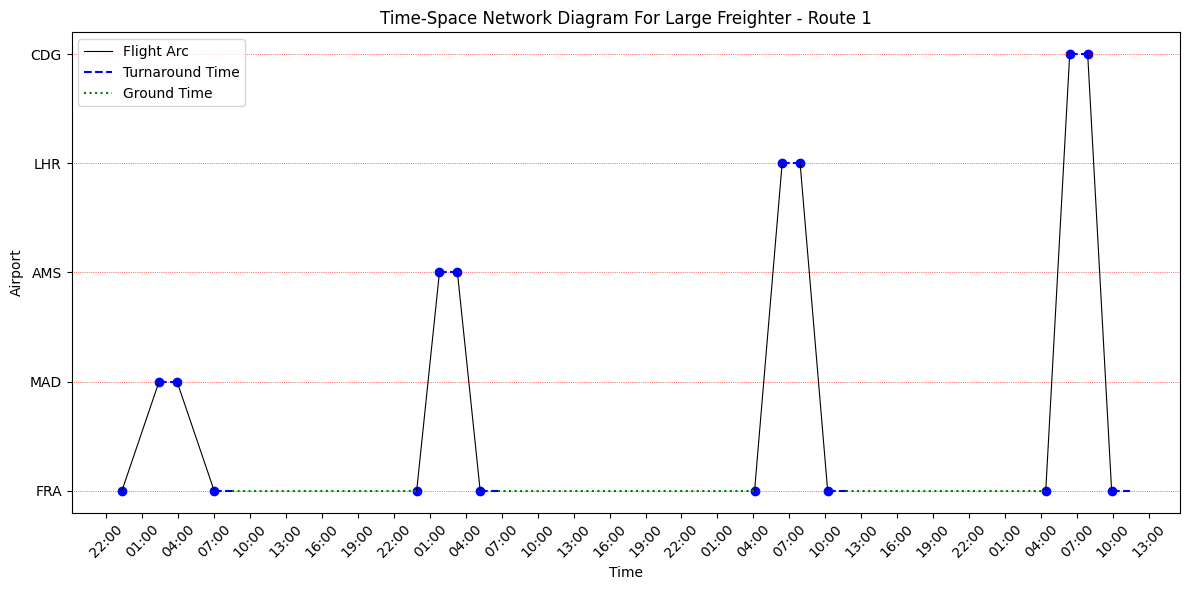

Plotting Time-Space Network Diagram for 1.2...
Saved plot to plots/1.2.png


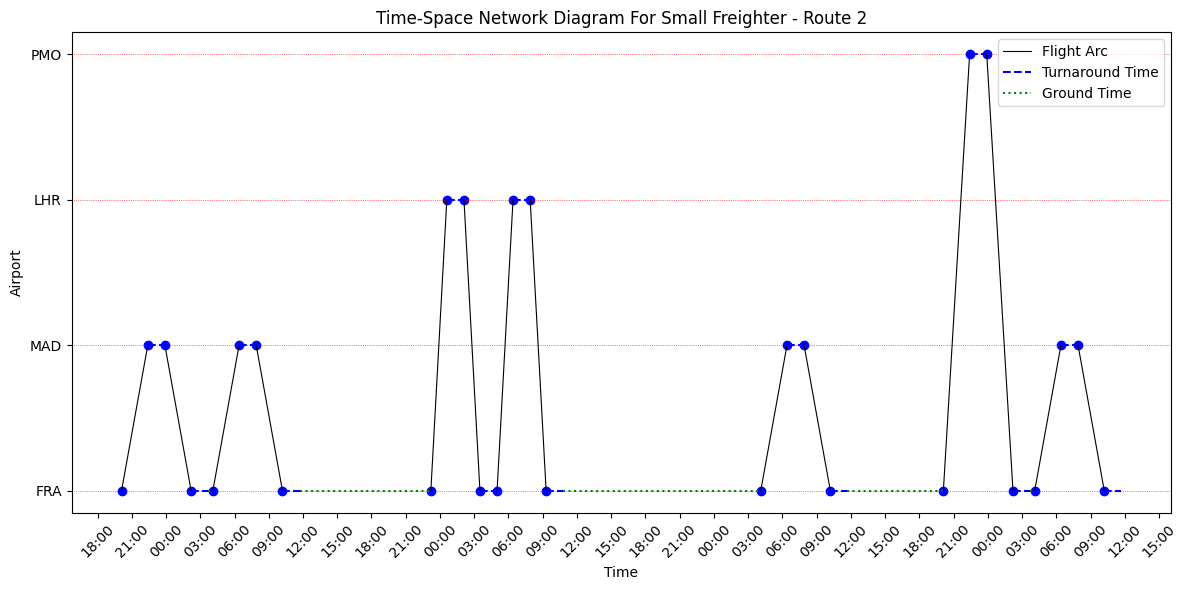

Plotting Time-Space Network Diagram for 1.3...
Saved plot to plots/1.3.png


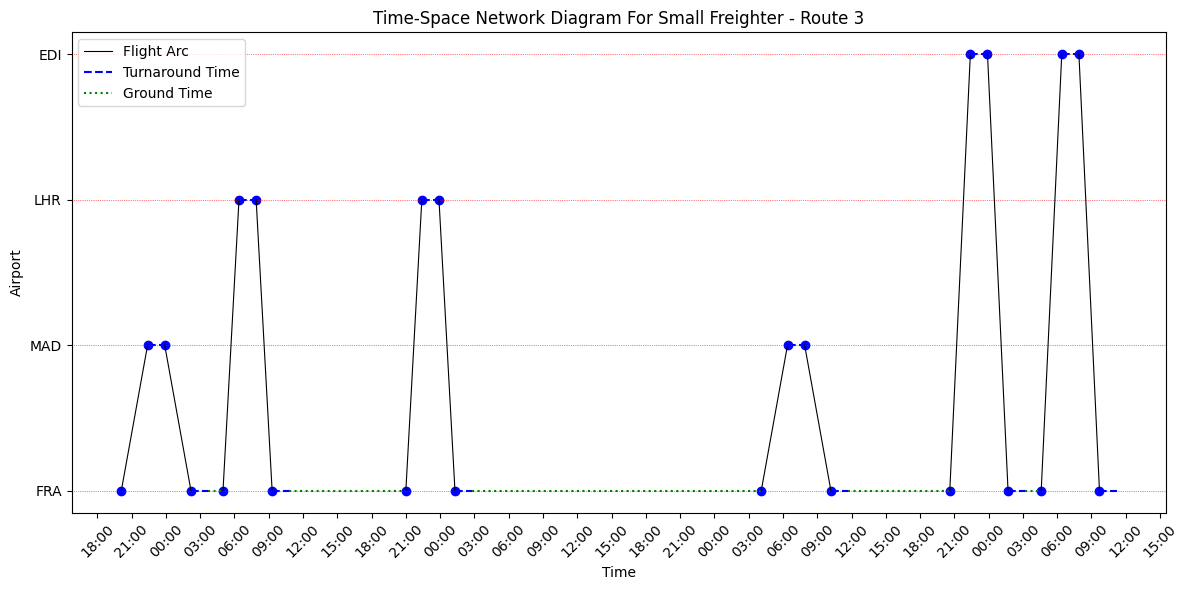

In [116]:
# output data in graphs 

def get_freighter_name(ac_type):
    freighter_names = {
        1: 'Small Freighter',
        2: 'Medium Freighter',
        3: 'Large Freighter'
    }
    return freighter_names.get(ac_type, 'Unknown Freighter')

def plot_time_space_diagram_from_planner(planner, route_name, save_path='plots'):
    ac_type, route_num = map(int, route_name.split('.'))  # Extract type and route number
    freighter_name = get_freighter_name(ac_type)
    title_name = f"{freighter_name} - Route {route_num}"

    airports = list(set([leg.split(' - ')[0] for leg in planner['Route']] + [leg.split(' - ')[1] for leg in planner['Route']]))
    airports.sort()  # Sort airports alphabetically for consistent y-axis

    # Create directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = {'Flight Arc': 'black', 'Turnaround Time': 'blue', 'Ground Time': 'green'}

    for i, row in planner.iterrows():
        origin, destination = row['Route'].split(' - ')
        dep_time = row['Departure Time']
        arr_time = row['Arrival Time'] - timedelta(minutes=90)  # Adjust arrival time to exclude turnaround time

        # Plot flight arc (departure to arrival)
        ax.plot([dep_time, arr_time], [origin, destination], label='Flight Arc', color=colors['Flight Arc'], linewidth=0.8)
        ax.scatter([dep_time], [origin], color='blue')  # Departure point
        ax.scatter([arr_time], [destination], color='blue')  # Arrival point

        # Plot turnaround time at the destination
        turnaround_start = arr_time
        turnaround_end = turnaround_start + timedelta(minutes=90)  # 90 minutes turnaround
        ax.plot([turnaround_start, turnaround_end], [destination, destination], linestyle='dashed', label='Turnaround Time', color=colors['Turnaround Time'])

        # Plot ground time if there is a delay before the next departure
        if i < len(planner) - 1:
            next_dep_time = planner.iloc[i + 1]['Departure Time']
            if next_dep_time > turnaround_end:
                ax.plot([turnaround_end, next_dep_time], [destination, destination], linestyle='dotted', label='Ground Time', color=colors['Ground Time'])

    # Format the x-axis for time
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45)
    
    # Set labels and title
    ax.set_title(f"Time-Space Network Diagram For {title_name}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Airport")
    ax.set_yticks(airports)
    
    # Customize grid lines
    ax.grid(visible=True, which='major', axis='y', color='red', linestyle=':', linewidth=0.5)  # Horizontal red dashed lines
    ax.grid(visible=False, axis='x')  # Remove vertical grid lines

    # Avoid duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.tight_layout()

    # Save the plot as a PNG
    file_name = f"{route_name.replace(' ', '_')}.png"
    file_path = os.path.join(save_path, file_name)
    plt.savefig(file_path, format='png')
    print(f"Saved plot to {file_path}")

    plt.show()

def plot_all_time_space_diagrams(routes_selected):
    for route_name, (profit, planner) in routes_selected.items():
        print(f"Plotting Time-Space Network Diagram for {route_name}...")
        plot_time_space_diagram_from_planner(planner, route_name)

plot_all_time_space_diagrams(routes_selected)
